# Reto Optimización: Modelo de Optimización Bio-Matemática para Reforestación

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.spatial import cKDTree
from typing import Dict, Tuple
from IPython.display import display


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data Collection

In [2]:
df_especie_poligono = pd.read_csv('cantidad_plantas_en_cada_poligono.csv').dropna(how="all")
df_especie_poligono = df_especie_poligono.drop('Unnamed: 31', axis=1)
df_especie_poligono

,Especies,Polígono 1,Polígono 2,Polígono 3,Polígono 4,Polígono 5,Polígono 6,Polígono 7,Polígono 8,Polígono 9,...,Polígono 21,Polígono 22,Polígono 23,Polígono 24,Polígono 25,Polígono 26,Polígono 27,Polígono 28,Polígono 29,Polígono 30
0,Agave lechuguilla,8.00,58.00,66.00,10.00,65.0,67.00,41.00,32.00,58.00,...,54.0,75.0,44.00,10.00,44.00,72.00,74.0,67.0,60.00,34.0
1,Agave salmiana,46.00,263.00,236.00,52.00,280.0,306.00,209.00,252.00,269.00,...,287.0,292.0,288.00,59.00,155.00,291.00,342.0,309.0,280.00,195.0
2,Agave scabra,16.00,47.00,51.00,15.00,66.0,63.00,43.00,46.00,58.00,...,70.0,60.0,69.00,15.00,28.00,73.00,52.0,67.0,61.00,56.0
3,Agave striata,16.00,49.00,50.00,9.00,61.0,61.00,49.00,40.00,53.00,...,62.0,68.0,51.00,11.00,31.00,50.00,55.0,66.0,53.00,58.0
4,Opuntia cantabrigiensis,11.00,60.00,71.00,15.00,92.0,81.00,48.00,73.00,57.00,...,89.0,104.0,69.00,17.00,39.00,66.00,70.0,86.0,76.00,55.0
5,Opuntia engelmannii,14.00,44.00,56.00,10.00,54.0,62.00,52.00,39.00,58.00,...,58.0,62.0,60.00,18.00,39.00,62.00,76.0,54.0,68.00,46.0
6,Opuntia robusta,18.00,111.00,100.00,18.00,124.0,118.00,87.00,86.00,94.00,...,126.0,109.0,122.00,17.00,65.00,125.00,100.0,120.0,109.00,91.0
7,Opuntia streptacantha,12.00,95.00,78.00,20.00,114.0,91.00,60.00,79.00,91.00,...,109.0,95.0,100.00,10.00,50.00,101.00,100.0,103.0,85.00,63.0
8,Prosopis laevigata,15.00,98.00,123.00,23.00,106.0,133.00,97.00,91.00,117.00,...,139.0,125.0,106.00,39.00,67.00,122.00,129.0,141.0,135.00,86.0
9,Yucca filifera,9.00,39.00,28.00,11.00,41.0,45.00,27.00,26.00,37.00,...,44.0,43.0,39.00,8.00,25.00,31.00,44.0,33.0,36.00,23.0


In [3]:
df_plantas_ha = pd.read_csv('plantas_porha.csv').dropna(how="all")
df_plantas_ha


,Especie,# Plantas por HA
0,Agave lechuguilla,42
1,Agave salmiana,196
2,Agave scabra,42
3,Agave striata,42
4,Opuntia cantabrigiensis,49
5,Opuntia engelmannii,38
6,Opuntia robusta,73
7,Opuntia streptacantha,64
8,Prosopis laevigata,86
9,Yucca filifera,26


In [4]:
# Limpieza y preparación de df_especie_poligono
df_ep = df_especie_poligono.dropna(how='all').copy()
df_ep = df_ep.rename(columns=lambda c: str(c).strip())
df_ep['Especies'] = df_ep['Especies'].str.strip()
df_ep = df_ep.set_index('Especies')

# Áreas por polígono (Ha)
areas = pd.to_numeric(df_ep.loc['Dimensión del polígono (Ha)'], errors='coerce')

# Conteos por especie y polígono (solo filas de especies)
conteos = df_ep.drop(index='Dimensión del polígono (Ha)').apply(pd.to_numeric, errors='coerce')

# Total de plantas por polígono y densidad actual por Ha
plantas_totales_poligono = conteos.sum(axis=0)
n_por_ha = plantas_totales_poligono / areas  # n = plantas/Ha ya plantadas

# Objetivo total por Ha (desde df_plantas_ha)
df_plantas_ha.columns = [c.strip() for c in df_plantas_ha.columns]
df_plantas_ha['Especie'] = df_plantas_ha['Especie'].str.strip()

total_requerido_ha = pd.to_numeric(
    df_plantas_ha.loc[df_plantas_ha['Especie'].str.upper().eq('TOTAL'), '# Plantas por HA'],
    errors='coerce'
).squeeze()

# Si no hubiera fila TOTAL, caemos a sumar por especie:
if pd.isna(total_requerido_ha):
    total_requerido_ha = pd.to_numeric(
        df_plantas_ha.loc[~df_plantas_ha['Especie'].str.upper().eq('TOTAL'), '# Plantas por HA'],
        errors='coerce'
    ).sum()

# Porcentaje de avance vs objetivo 658
porcentaje_plantado = (n_por_ha / total_requerido_ha) * 100

# Reordenar el resultado según el orden numérico de los polígonos
def orden_poligonos(idx):
    # Extrae el número del nombre, por ej. 'Polígono 14' -> 14
    import re
    nums = idx.str.extract(r'(\d+)')
    return nums[0].astype(int)

resultado = pd.DataFrame({
    'n_plantas_por_ha_actual': n_por_ha.round(2),
    'porcentaje_plantado': porcentaje_plantado.round(1)
})

# Solo dejamos los polígonos cuyo nombre encaje con el patrón "Polígono" y un número
resultado_poligonos = resultado[resultado.index.str.match(r'Polígono\s*\d+', na=False)].copy()
resultado_poligonos = resultado_poligonos.iloc[orden_poligonos(resultado_poligonos.index).argsort()]

# Si quieres mostrar sólo los polígonos en orden (puedes ajustar si quieres el resultado completo):
resultado_poligonos

,n_plantas_por_ha_actual,porcentaje_plantado
Polígono 1,128.91,19.6
Polígono 2,130.12,19.8
Polígono 3,127.07,19.3
Polígono 4,132.61,20.2
Polígono 5,125.38,19.1
Polígono 6,131.33,20.0
Polígono 7,128.93,19.6
Polígono 8,135.46,20.6
Polígono 9,125.46,19.1
Polígono 10,123.90,18.8


In [5]:
average_porcentaje_plantado = resultado_poligonos['porcentaje_plantado'].mean()/100
average_porcentaje_plantado

0.19643333333333332

In [6]:
# Probabilidades de plantar por especie en una hectárea (basadas en df_especie_poligono)
# Requiere que existan las variables `conteos` (matriz especies x polígonos) y `areas` (serie con ha por polígono)

objetivo_ha = 658  # plantas por hectárea

# Densidad por especie (plantas por Ha) agregada a nivel global = total especie / total área
densidad_por_especie = conteos.sum(axis=1) / areas.sum()

densidad_total = densidad_por_especie.sum()

# Probabilidad (mezcla) de cada especie al elegir una planta al azar (normaliza a 1)
prob_especie = (densidad_por_especie / densidad_total).rename('probabilidad')

probabilidades_especie = (
    pd.concat([prob_especie], axis=1)
)

probabilidades_especie

,probabilidad
Especies,
Agave lechuguilla,0.063261
Agave salmiana,0.295133
Agave scabra,0.062031
Agave striata,0.059570
Opuntia cantabrigiensis,0.077729
Opuntia engelmannii,0.061903
Opuntia robusta,0.116509
Opuntia streptacantha,0.097119
Prosopis laevigata,0.128050


In [7]:
df_competencia = pd.read_csv('matriz_competencia_plantas1.csv')
df_competencia = df_competencia.replace('—', 4).replace('-', 4)
df_competencia

,Unnamed: 0,Agave lechuguilla,Agave salmiana,Agave scabra,Agave striata,Opuntia cantabrigiensis,Opuntia engelmannii,Opuntia robusta,Opuntia streptacantha,Prosopis laevigata,Yucca filifera
0,Agave lechuguilla,4,2,2,3,1,1,1,1,3,2
1,Agave salmiana,2,4,3,3,2,2,2,2,3,3
2,Agave scabra,2,3,4,2,1,2,2,1,2,3
3,Agave striata,3,3,2,4,1,1,2,1,2,2
4,Opuntia cantabrigiensis,1,2,1,1,4,2,3,2,1,1
5,Opuntia engelmannii,1,2,2,1,2,4,3,3,2,1
6,Opuntia robusta,1,2,2,2,3,3,4,3,2,2
7,Opuntia streptacantha,1,2,1,1,2,3,3,4,2,1
8,Prosopis laevigata,3,3,2,2,1,2,2,2,4,3
9,Yucca filifera,2,3,3,2,1,1,2,1,3,4


## Optimizacion

Nodos totales (1 ha): 658
Nodos ya plantados: 148 (22.5%)

Porcentaje por especie (sobre nodos ocupados):
Agave lechuguilla: 12.16%
Agave salmiana: 30.41%
Agave scabra: 6.76%
Agave striata: 5.41%
Opuntia cantabrigiensis: 6.08%
Opuntia engelmannii: 5.41%
Opuntia robusta: 8.78%
Opuntia streptacantha: 7.43%
Prosopis laevigata: 14.86%
Yucca filifera: 2.70%


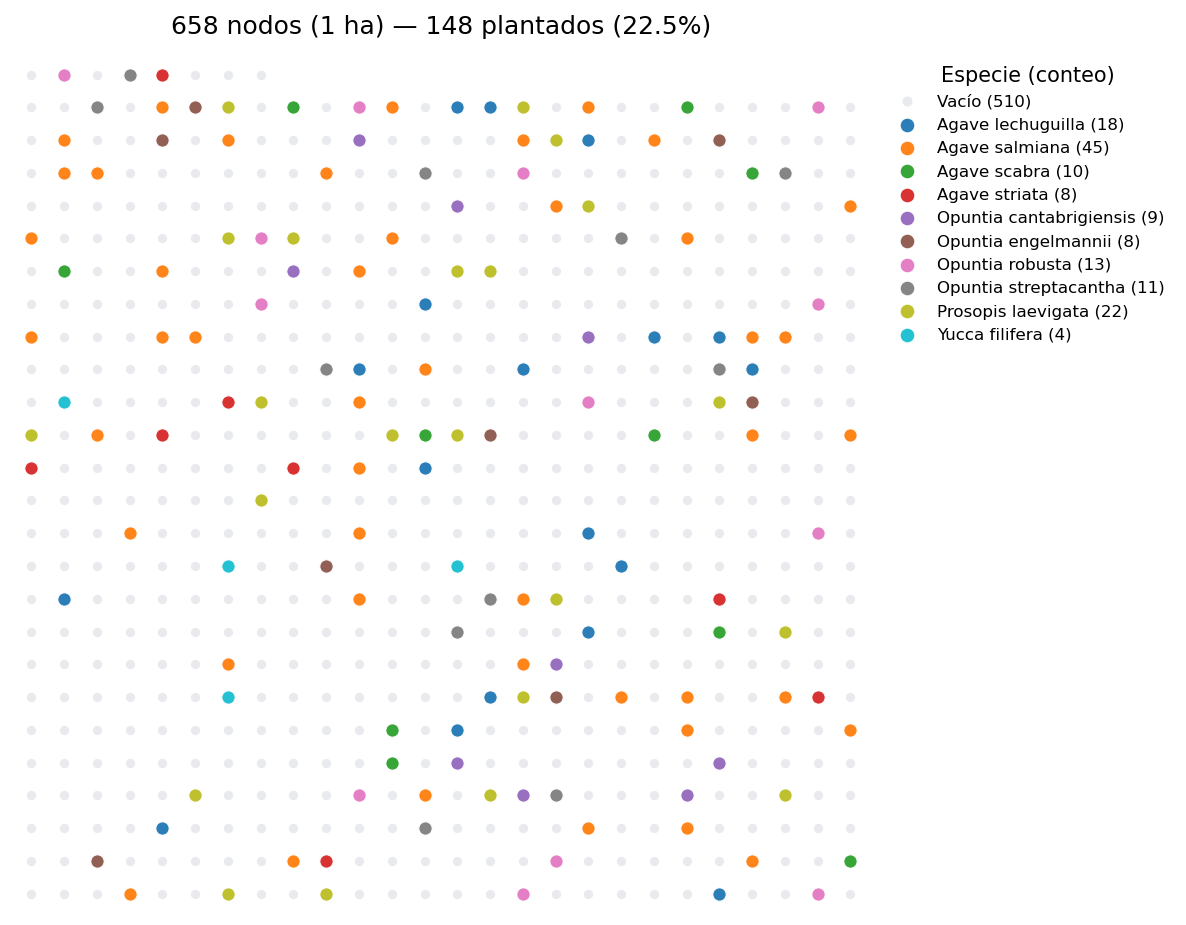

In [8]:
# Parámetros
N_NODOS = 658
PRE_EXISTING_RATE = 0.196  # 19.6% de nodos ya plantados
SEED = random.randint(1, 1000000)
rng = np.random.default_rng(SEED)

# Probabilidades por especie desde 'probabilidades_especie'
if 'probabilidades_especie' not in globals():
    raise NameError("No se encontró 'probabilidades_especie'. Ejecútalo antes de este bloque.")
species_names = probabilidades_especie.index.astype(str).str.strip().tolist()
probs = np.asarray(probabilidades_especie['probabilidad'], dtype=float)
if not np.isfinite(probs).all() or probs.sum() <= 0:
    raise ValueError("Probabilidades inválidas en 'probabilidades_especie'.")
probs = np.maximum(probs, 0)
probs = probs / probs.sum()

# Layout cuadrado normalizado (abstracto: 658 nodos = 1 ha)
n_cols = int(np.ceil(np.sqrt(N_NODOS)))
n_rows = int(np.ceil(N_NODOS / n_cols))
xs, ys = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
coords = np.column_stack([xs.ravel(), ys.ravel()])[:N_NODOS].astype(float)
# Normaliza a [0, 1] para el área de dibujo
for j in (0, 1):
    ptp = coords[:, j].ptp()
    coords[:, j] = (coords[:, j] - coords[:, j].min()) / (ptp if ptp > 0 else 1)

# Ocupación Bernoulli: 19.6% de nodos con planta
occupied = rng.random(N_NODOS) < PRE_EXISTING_RATE
n_planted = int(occupied.sum())

# Asignación de especies para los ocupados según 'probs'
if n_planted > 0:
    sp_idx = rng.choice(len(species_names), size=n_planted, p=probs, replace=True)
    sp_assigned = [species_names[i] for i in sp_idx]
    planted_pts = coords[occupied]
    df_planted = pd.DataFrame({"x": planted_pts[:, 0], "y": planted_pts[:, 1], "species": sp_assigned})
else:
    df_planted = pd.DataFrame(columns=["x", "y", "species"])

# Resumen por especie
counts = df_planted['species'].value_counts().reindex(species_names, fill_value=0)
percent = (counts / max(counts.sum(), 1)) * 100.0
summary = pd.DataFrame({"Especie": counts.index, "Conteo": counts.values, "Porcentaje": percent.values})

print(f"Nodos totales (1 ha): {N_NODOS}")
print(f"Nodos ya plantados: {n_planted} ({100*n_planted/N_NODOS:.1f}%)\n")
print("Porcentaje por especie (sobre nodos ocupados):")
for sp, p in zip(summary['Especie'], summary['Porcentaje']):
    print(f"{sp}: {p:.2f}%")

# Paleta y estilos de plot
tab10 = plt.get_cmap('tab10').colors
color_map = {sp: tab10[i % len(tab10)] for i, sp in enumerate(species_names)}

plt.figure(figsize=(8, 8), dpi=150)

# Vacíos en gris tenue
empty_pts = coords[~occupied]
plt.scatter(empty_pts[:, 0], empty_pts[:, 1], s=12, color="#E8EAED", label=f"Vacío ({len(empty_pts)})", zorder=1)

# Plantas por especie con borde blanco
for sp in species_names:
    if counts[sp] > 0:
        m = df_planted['species'].eq(sp).values
        plt.scatter(df_planted.loc[m, "x"], df_planted.loc[m, "y"],
                    s=42, color=color_map[sp], edgecolors="white", linewidths=0.6,
                    alpha=0.95, label=f"{sp} ({counts[sp]})", zorder=3)

plt.gca().set_aspect('equal', adjustable='box')
plt.margins(0.02)
plt.axis('off')
plt.title(f"658 nodos (1 ha) — {n_planted} plantados ({100*n_planted/N_NODOS:.1f}%)", pad=12)

# Leyenda compacta a la derecha
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0,
           frameon=False, fontsize=8, title="Especie (conteo)", markerscale=1.1)

plt.tight_layout()
plt.show()




====== RESULTADOS: SIN COEXISTENCIA ======
Sumas:
 - Target total: 658
 - Iniciales: 148
 - Final total: 658

Resumen por especie:


,Especie,Target_658,Iniciales,Plantadas_nuevas,Final_total,Error_vs_target
0,Agave lechuguilla,42,18,24,42,0
1,Agave salmiana,196,45,151,196,0
2,Agave scabra,42,10,32,42,0
3,Agave striata,42,8,34,42,0
4,Opuntia cantabrigiensis,49,9,40,49,0
5,Opuntia engelmannii,38,8,30,38,0
6,Opuntia robusta,73,13,60,73,0
7,Opuntia streptacantha,64,11,53,64,0
8,Prosopis laevigata,86,22,64,86,0
9,Yucca filifera,26,4,22,26,0


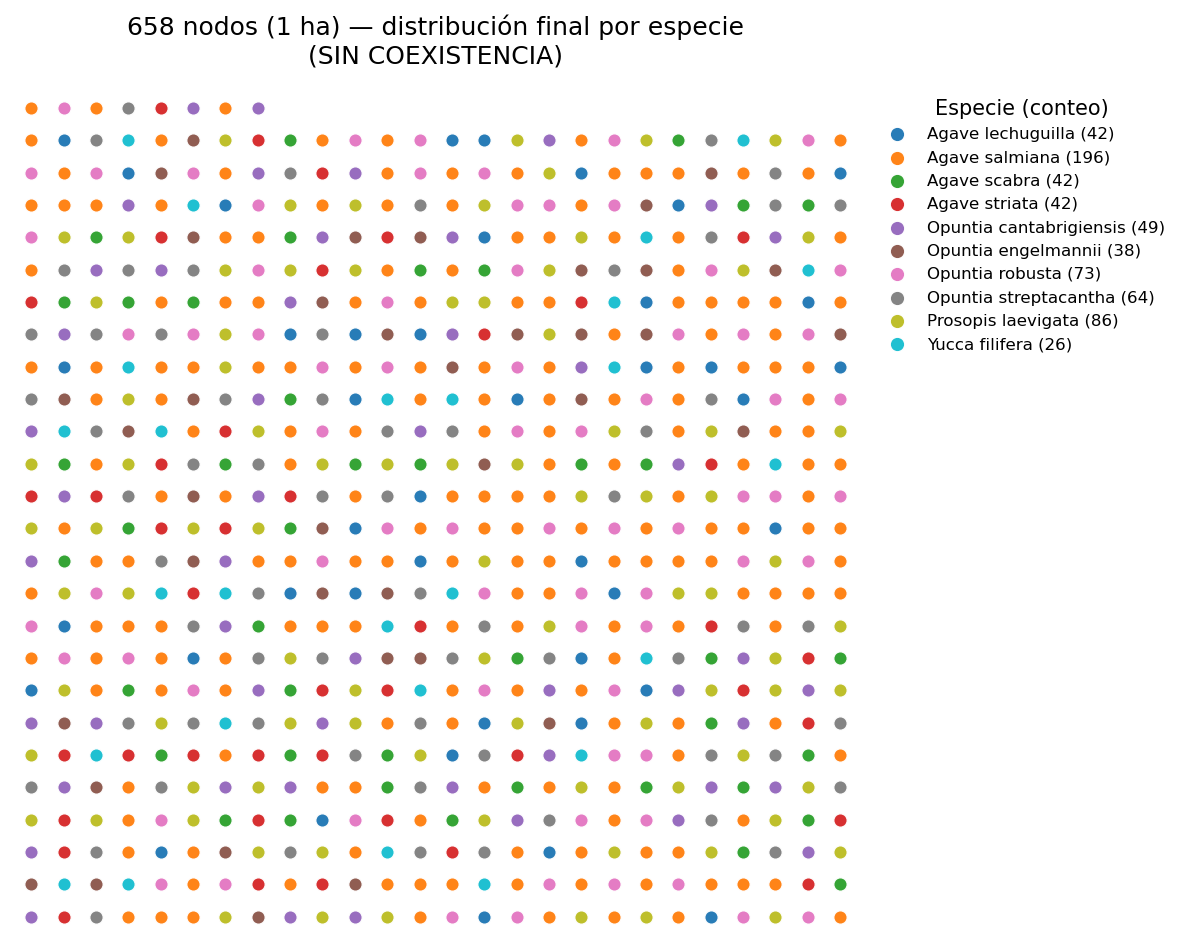



====== RESULTADOS: COEXISTENCIA NEUTRA ======
Sumas:
 - Target total: 658
 - Iniciales: 148
 - Final total: 658

Resumen por especie:


,Especie,Target_658,Iniciales,Plantadas_nuevas,Final_total,Error_vs_target
0,Agave lechuguilla,42,18,24,42,0
1,Agave salmiana,196,45,151,196,0
2,Agave scabra,42,10,32,42,0
3,Agave striata,42,8,34,42,0
4,Opuntia cantabrigiensis,49,9,40,49,0
5,Opuntia engelmannii,38,8,30,38,0
6,Opuntia robusta,73,13,60,73,0
7,Opuntia streptacantha,64,11,53,64,0
8,Prosopis laevigata,86,22,64,86,0
9,Yucca filifera,26,4,22,26,0


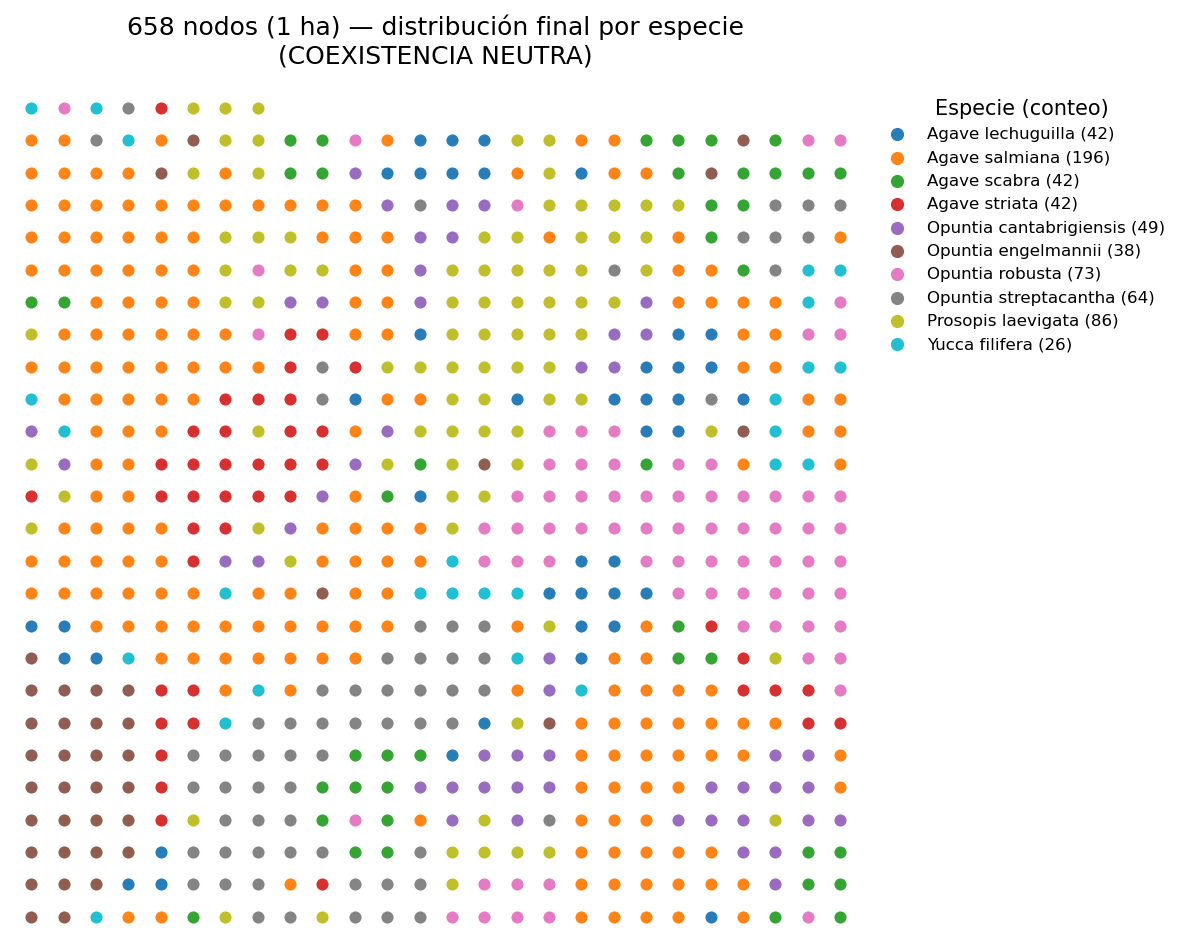

In [9]:
# Plantado óptimo (heurístico voraz):
# Comparación con dos matrices de competencia: 
#   - Alta competencia entre especies ("Sin coexistencia")
#   - Coexistencia neutra ("Competencia baja")

def cargar_metas_y_comp(species_order, modo="alta"):
    """
    modo:
      - "alta": competencia alta entre especies (no coexistencia, valor alto fuera de diagonal)
      - "neutra": baja competencia entre especies (valores bajos fuera de diagonal)
    """
    # Metas
    try:
        df_ph = df_plantas_ha.copy()
    except NameError:
        df_ph = df_plantas_ha
    df_ph.columns = [c.strip() for c in df_ph.columns]
    df_ph['Especie'] = df_ph['Especie'].str.strip()
    df_ph = df_ph[df_ph['Especie'].str.upper() != 'TOTAL'].copy()
    metas = pd.Series(df_ph.set_index('Especie')['# Plantas por HA'], name='target').astype(float)    
    metas = metas.reindex(species_order).fillna(0.0)
    metas = metas * (N_NODOS / metas.sum())
    target_counts = np.rint(metas.values).astype(int)
    diff = N_NODOS - target_counts.sum()
    if diff != 0 and len(target_counts) > 0:
        order = np.argsort(-metas.values)
        for i in range(abs(diff)):
            idx = order[i % len(order)]
            target_counts[idx] += 1 if diff > 0 else -1
        target_counts = np.maximum(target_counts, 0)

    # Matriz de competencia según modo
    comp_df = pd.read_csv("matriz_competencia_plantas1.csv", index_col=0)
    comp_df.columns = comp_df.columns.str.strip()
    comp_df.index = comp_df.index.str.strip()
    if modo == "alta":
        # Sin coexistencia: todo 4 fuera de diagonal (luego normalizado a ~1.333)
        comp_df = comp_df.replace({'—': 4, '–': 4, '-': 4}).apply(pd.to_numeric, errors='coerce').fillna(4)
        comp_df = comp_df.reindex(index=species_order, columns=species_order).fillna(4)
        comp = comp_df.values.astype(float)
        np.fill_diagonal(comp, 4.0)
        comp = comp / 3.0
    elif modo == "neutra":
        # Coexistencia neutra: todo 0 fuera de diagonal (normalizado)
        comp_df = comp_df.replace({'—': 0, '–': 0, '-': 0}).apply(pd.to_numeric, errors='coerce').fillna(0)
        comp_df = comp_df.reindex(index=species_order, columns=species_order).fillna(0)
        comp = comp_df.values.astype(float)
        comp = comp / 3.0
        np.fill_diagonal(comp, 0.0)
    else:
        raise ValueError("modo debe ser 'alta' o 'neutra'")
    return target_counts, comp

def preparar_y_greedy_fill(target_counts, comp, species_order, modo_leyenda=""):
    # Construye variables igual que antes pero permite reiniciar para ambos modos
    n_cols = int(np.ceil(np.sqrt(N_NODOS)))
    n_rows = int(np.ceil(N_NODOS / n_cols))
    rows = np.arange(N_NODOS) // n_cols
    cols = np.arange(N_NODOS) % n_cols
    neighbors = [[] for _ in range(N_NODOS)]
    for i in range(N_NODOS):
        r, c = rows[i], cols[i]
        for dr in (-1, 0, 1):
            for dc in (-1, 0, 1):
                if dr == 0 and dc == 0:
                    continue
                rr, cc = r + dr, c + dc
                if 0 <= rr < n_rows and 0 <= cc < n_cols:
                    j = rr * n_cols + cc
                    if j < N_NODOS:
                        neighbors[i].append(j)
    neighbors = [np.array(n, dtype=int) for n in neighbors]

    sp2idx = {sp: k for k, sp in enumerate(species_order)}
    occupied_mask = np.zeros(N_NODOS, dtype=bool)
    species_at = -np.ones(N_NODOS, dtype=int)
    if len(df_planted) > 0:
        tree = cKDTree(coords)
        assigned_idx = tree.query(df_planted[['x','y']].values, k=1)[1]
        assigned_idx = assigned_idx.astype(int)
        for node_i, sp in zip(assigned_idx, df_planted['species'].astype(str).str.strip()):
            if 0 <= node_i < N_NODOS and sp in sp2idx:
                occupied_mask[node_i] = True
                species_at[node_i] = sp2idx[sp]

    current_counts = np.zeros(len(species_order), dtype=int)
    for k in species_at[species_at != -1]:
        current_counts[k] += 1
    need = target_counts - current_counts
    need = np.maximum(need, 0)
    empty_idx = np.where(~occupied_mask)[0]
    total_to_plant = int(min(need.sum(), len(empty_idx)))
    if need.sum() > total_to_plant:
        if need.sum() > 0:
            need = np.rint(need * (total_to_plant / need.sum())).astype(int)
        diff = total_to_plant - need.sum()
        if diff != 0:
            order = np.argsort(-need)
            for i in range(abs(diff)):
                idx = order[i % len(order)]
                need[idx] += 1 if diff > 0 else -1
            need = np.maximum(need, 0)

    def compute_cost_for(node_i, sp_idx):
        nbrs = neighbors[node_i]
        nbr_species = species_at[nbrs]
        nbr_species = nbr_species[nbr_species != -1]
        if nbr_species.size == 0:
            return 0.0
        return comp[sp_idx, nbr_species].mean()

    def greedy_fill():
        nonlocal species_at, occupied_mask
        remaining = need.copy()
        max_needed = max(remaining.max(), 1)
        empties = set(empty_idx.tolist())
        occupied_deg = np.array([np.sum(species_at[nbrs] != -1) for nbrs in neighbors])
        candidate_nodes = sorted(empties, key=lambda u: occupied_deg[u], reverse=True)
        while remaining.sum() > 0 and len(empties) > 0:
            best = None
            best_score = -1e9
            K = min(200, len(candidate_nodes))
            nodes_to_check = candidate_nodes[:K]
            for u in nodes_to_check:
                if u not in empties:
                    continue
                if remaining.sum() == 0:
                    break
                for s_idx, rem in enumerate(remaining):
                    if rem <= 0:
                        continue
                    benefit = rem / max_needed
                    cost = compute_cost_for(u, s_idx)
                    score = benefit - LAMBDA_COMP * cost
                    if score > best_score:
                        best_score = score
                        best = (u, s_idx)
            if best is None:
                break
            u, s_idx = best
            species_at[u] = s_idx
            occupied_mask[u] = True
            remaining[s_idx] -= 1
            empties.remove(u)
            for v in neighbors[u]:
                occupied_deg[v] += 1
            if u in candidate_nodes:
                candidate_nodes.remove(u)
            candidate_nodes = sorted(candidate_nodes, key=lambda x: occupied_deg[x], reverse=True)
    greedy_fill()

    # Resultados finales
    final_species = np.array(species_order)[np.where(species_at==-1, 0, species_at)]
    final_counts = pd.Series(0, index=species_order)
    for k in species_at:
        if k != -1:
            final_counts.iloc[k] += 1

    resumen_final = pd.DataFrame({
        "Especie": species_order,
        "Target_658": target_counts,
        "Iniciales": current_counts,
        "Plantadas_nuevas": (final_counts.values - current_counts),
        "Final_total": final_counts.values
    })
    resumen_final["Error_vs_target"] = resumen_final["Final_total"] - resumen_final["Target_658"]

    print(f"\n\n====== RESULTADOS: {modo_leyenda} ======")
    print("Sumas:")
    print(" - Target total:", int(target_counts.sum()))
    print(" - Iniciales:", int(current_counts.sum()))
    print(" - Final total:", int(final_counts.sum()))
    print("\nResumen por especie:")
    display(resumen_final)

    # Graficar
    tab10 = plt.get_cmap('tab10').colors
    color_map = {sp: tab10[i % len(tab10)] for i, sp in enumerate(species_order)}
    plt.figure(figsize=(8, 8), dpi=150)
    empty_pts = coords[species_at == -1]
    if len(empty_pts) > 0:
        plt.scatter(empty_pts[:, 0], empty_pts[:, 1], s=14, color="#E8EAED", label=f"Vacío ({len(empty_pts)})", zorder=1)
    for idx, sp in enumerate(species_order):
        pts = coords[species_at == idx]
        if len(pts) > 0:
            plt.scatter(pts[:, 0], pts[:, 1],
                        s=42, color=color_map[sp], edgecolors="white", linewidths=0.68, alpha=0.96,
                        label=f"{sp} ({np.sum(species_at == idx)})", zorder=3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.margins(0.02)
    plt.axis('off')
    plt.title(f"658 nodos (1 ha) — distribución final por especie\n({modo_leyenda})", pad=14)
    plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0,
               frameon=False, fontsize=8, title="Especie (conteo)", markerscale=1.08)
    plt.tight_layout()
    plt.show()
    # Devuelve estado final por si se quiere evaluar métricas luego
    return dict(species_at=species_at.copy(),
                resumen=resumen_final.copy(),
                neighbors=neighbors, comp=comp, target_counts=target_counts, species_order=species_order)

# ---- Ejecutar ambos experimentos ----
species_order = list(species_names)
N_NODOS = 658
LAMBDA_COMP = 1

# (A) Alta competencia (no coexistencia)
target_counts_alta, comp_alta = cargar_metas_y_comp(species_order, modo="alta")
res_alta = preparar_y_greedy_fill(target_counts_alta, comp_alta, species_order, modo_leyenda="SIN COEXISTENCIA")

# (B) Coexistencia neutra
target_counts_neutra, comp_neutra = cargar_metas_y_comp(species_order, modo="neutra")
res_neutra = preparar_y_greedy_fill(target_counts_neutra, comp_neutra, species_order, modo_leyenda="COEXISTENCIA NEUTRA")


In [10]:
# Métricas de eficacia + comparación con baseline aleatorio

def js_divergence(p, q, eps=1e-12):
    p = np.clip(p, eps, 1); p = p / p.sum()
    q = np.clip(q, eps, 1); q = q / q.sum()
    m = 0.5*(p+q)
    kl = lambda a,b: np.sum(a*np.log(a/b))
    return 0.5*kl(p,m) + 0.5*kl(q,m)

def metrics(species_at, target_counts, neighbors, comp):
    N = len(species_at)
    occ = species_at != -1
    final_counts = np.bincount(species_at[occ], minlength=len(target_counts))
    # 1) Adherencia a meta
    l1_abs = np.abs(final_counts - target_counts).sum()
    perc_error = 100.0 * l1_abs / max(N,1)
    p_final = final_counts / max(final_counts.sum(), 1)
    p_target = target_counts / max(target_counts.sum(), 1)
    jsd = js_divergence(p_final, p_target)  # menor = mejor

    # 2) Competencia: promedio por par vecino ocupado y promedio por planta
    sum_pairs = 0.0; cnt_pairs = 0
    per_node_cost = np.zeros(N, dtype=float)
    for i in range(N):
        si = species_at[i]
        if si == -1: 
            continue
        nbrs = neighbors[i]
        # Solo cuenta pares i<j para evitar doble conteo
        for j in nbrs[nbrs > i]:
            sj = species_at[j]
            if sj == -1: 
                continue
            c = comp[si, sj]
            sum_pairs += c; cnt_pairs += 1
        # costo medio de sus vecinos (para promedio por planta)
        nbr_occ = [j for j in nbrs if species_at[j] != -1]
        if nbr_occ:
            per_node_cost[i] = np.mean([comp[si, species_at[j]] for j in nbr_occ])

    mean_comp_pair = sum_pairs / cnt_pairs if cnt_pairs > 0 else 0.0
    mean_comp_per_plant = per_node_cost[occ].mean() if occ.any() else 0.0

    return {
        "final_counts": final_counts,
        "perc_error_vs_target": perc_error,
        "js_divergence": jsd,
        "mean_comp_pair": mean_comp_pair,
        "mean_comp_per_plant": mean_comp_per_plant,
    }

# --- Imprime métricas para ambas matrices de competencia ---
experimentos = [
    ("Alta competencia (SIN COEXISTENCIA)", res_alta, target_counts_alta, comp_alta),
    ("Coexistencia neutra (Competencia baja)", res_neutra, target_counts_neutra, comp_neutra),
]

for nombre, resultado, t_counts, compmat in experimentos:
    print(f"\n--- {nombre} ---")
    met = metrics(resultado['species_at'], t_counts, resultado['neighbors'], compmat)
    print(f"- Error % vs target (L1/658): {met['perc_error_vs_target']:.2f}%")
    print(f"- JS divergence dist. final vs target: {met['js_divergence']:.4f}")
    print(f"- Competencia promedio por par vecino: {met['mean_comp_pair']:.4f}")
    print(f"- Competencia promedio por planta: {met['mean_comp_per_plant']:.4f}")



--- Alta competencia (SIN COEXISTENCIA) ---
- Error % vs target (L1/658): 0.00%
- JS divergence dist. final vs target: 0.0000
- Competencia promedio por par vecino: 0.7114
- Competencia promedio por planta: 0.7108

--- Coexistencia neutra (Competencia baja) ---
- Error % vs target (L1/658): 0.00%
- JS divergence dist. final vs target: 0.0000
- Competencia promedio por par vecino: 0.3038
- Competencia promedio por planta: 0.3062


## Simulaciones y Convergencia 

In [11]:
# === Simulaciones Monte Carlo y Reporte ===
# Calcula valores esperados y matriz de transición por especie bajo modos de competencia



def _construir_vecindad(n_nodos: int) -> Tuple[np.ndarray, np.ndarray, list]:
    n_cols = int(np.ceil(np.sqrt(n_nodos)))
    n_rows = int(np.ceil(n_nodos / n_cols))
    rows = np.arange(n_nodos) // n_cols
    cols = np.arange(n_nodos) % n_cols
    neighbors = [[] for _ in range(n_nodos)]
    for i in range(n_nodos):
        r, c = rows[i], cols[i]
        for dr in (-1, 0, 1):
            for dc in (-1, 0, 1):
                if dr == 0 and dc == 0:
                    continue
                rr, cc = r + dr, c + dc
                if 0 <= rr < n_rows and 0 <= cc < n_cols:
                    j = rr * n_cols + cc
                    if j < n_nodos:
                        neighbors[i].append(j)
    neighbors = [np.array(n, dtype=int) for n in neighbors]
    return rows, cols, neighbors


def _competencia_promedio(species_at: np.ndarray, comp: np.ndarray, neighbors: list) -> float:
    total_cost = 0.0
    total_deg = 0
    for i, nbrs in enumerate(neighbors):
        si = species_at[i]
        if si == -1:
            continue
        nbr_species = species_at[nbrs]
        mask = nbr_species != -1
        if not np.any(mask):
            continue
        total_cost += comp[si, nbr_species[mask]].sum()
        total_deg += int(mask.sum())
    if total_deg == 0:
        return 0.0
    return float(total_cost / total_deg)


def _greedy_asignacion(target_counts: np.ndarray, comp: np.ndarray, species_order: list,
                        coords: np.ndarray, df_planted_local: pd.DataFrame, lambda_comp: float = 1.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray, list, np.ndarray]:
    n_nodos = coords.shape[0]
    _, _, neighbors = _construir_vecindad(n_nodos)

    sp2idx = {sp: k for k, sp in enumerate(species_order)}
    occupied_mask = np.zeros(n_nodos, dtype=bool)
    species_at = -np.ones(n_nodos, dtype=int)

    if len(df_planted_local) > 0:
        tree = cKDTree(coords)
        assigned_idx = tree.query(df_planted_local[['x', 'y']].values, k=1)[1].astype(int)
        for node_i, sp in zip(assigned_idx, df_planted_local['species'].astype(str).str.strip()):
            if 0 <= node_i < n_nodos and sp in sp2idx:
                occupied_mask[node_i] = True
                species_at[node_i] = sp2idx[sp]

    current_counts = np.zeros(len(species_order), dtype=int)
    for k in species_at[species_at != -1]:
        current_counts[k] += 1

    need = np.maximum(target_counts - current_counts, 0)

    empty_idx = np.where(~occupied_mask)[0]
    total_to_plant = int(min(need.sum(), len(empty_idx)))
    if need.sum() > total_to_plant:
        if need.sum() > 0:
            need = np.rint(need * (total_to_plant / need.sum())).astype(int)
        diff = total_to_plant - need.sum()
        if diff != 0:
            order = np.argsort(-need)
            for i in range(abs(diff)):
                idx = order[i % len(order)]
                need[idx] += 1 if diff > 0 else -1
            need = np.maximum(need, 0)

    species_at_init = species_at.copy()

    def compute_cost_for(node_i: int, sp_idx: int) -> float:
        nbrs = neighbors[node_i]
        nbr_species = species_at[nbrs]
        nbr_species = nbr_species[nbr_species != -1]
        if nbr_species.size == 0:
            return 0.0
        return float(comp[sp_idx, nbr_species].mean())

    remaining = need.copy()
    max_needed = max(int(remaining.max()) if remaining.size > 0 else 0, 1)
    empties = set(empty_idx.tolist())
    occupied_deg = np.array([np.sum(species_at[nbrs] != -1) for nbrs in neighbors])
    candidate_nodes = sorted(empties, key=lambda u: occupied_deg[u], reverse=True)

    while remaining.sum() > 0 and len(empties) > 0:
        best = None
        best_score = -1e9
        K = min(200, len(candidate_nodes))
        nodes_to_check = candidate_nodes[:K]
        for u in nodes_to_check:
            if u not in empties:
                continue
            if remaining.sum() == 0:
                break
            for s_idx, rem in enumerate(remaining):
                if rem <= 0:
                    continue
                benefit = rem / max_needed
                cost = compute_cost_for(u, s_idx)
                score = benefit - lambda_comp * cost
                if score > best_score:
                    best_score = score
                    best = (u, s_idx)
        if best is None:
            break
        u, s_idx = best
        species_at[u] = s_idx
        occupied_mask[u] = True
        remaining[s_idx] -= 1
        empties.remove(u)
        for v in neighbors[u]:
            occupied_deg[v] += 1
        if u in candidate_nodes:
            candidate_nodes.remove(u)
        candidate_nodes = sorted(candidate_nodes, key=lambda x: occupied_deg[x], reverse=True)

    final_counts = np.zeros(len(species_order), dtype=int)
    for k in species_at[species_at != -1]:
        final_counts[k] += 1

    return species_at, current_counts, final_counts, neighbors, species_at_init


def _matriz_transicion(species_at: np.ndarray, neighbors: list, n_species: int) -> np.ndarray:
    counts = np.zeros((n_species, n_species), dtype=np.int64)
    for i, nbrs in enumerate(neighbors):
        si = species_at[i]
        if si == -1:
            continue
        nbr_species = species_at[nbrs]
        for sj in nbr_species[nbr_species != -1]:
            counts[si, sj] += 1
    return counts


def monte_carlo_reporte(N_SIM, modos=("alta", "neutra"), seed_base: int | None = None, lambda_comp: float = 1.0) -> Dict[str, dict]:
    if 'probabilidades_especie' not in globals():
        raise NameError("No se encontró 'probabilidades_especie'. Ejecuta la celda de probabilidades antes de esta.")
    species_order = list(species_names)
    n_species = len(species_order)
    base_seed = int(SEED) if seed_base is None else int(seed_base)

    resultados: Dict[str, dict] = {}

    for modo in modos:
        sum_exist_total = 0.0
        sum_exist_by_sp = np.zeros(n_species, dtype=float)
        sum_supply_by_sp = np.zeros(n_species, dtype=float)
        sum_comp_init = 0.0
        sum_comp_final = 0.0
        trans_counts_acc = np.zeros((n_species, n_species), dtype=np.int64)

        for s in range(N_SIM):
            rng_sim = np.random.default_rng(base_seed + s + (0 if modo == "alta" else 10_000_000))

            # Inicial: ocupación y especies preexistentes
            occupied = rng_sim.random(N_NODOS) < PRE_EXISTING_RATE
            n_planted = int(occupied.sum())
            if n_planted > 0:
                sp_idx = rng_sim.choice(n_species, size=n_planted, p=probs, replace=True)
                sp_assigned = [species_order[i] for i in sp_idx]
                planted_pts = coords[occupied]
                df_planted_local = pd.DataFrame({"x": planted_pts[:, 0], "y": planted_pts[:, 1], "species": sp_assigned})
            else:
                df_planted_local = pd.DataFrame(columns=["x", "y", "species"])

            # Metas y matriz de competencia
            target_counts, comp = cargar_metas_y_comp(species_order, modo=modo)

            # Asignación voraz (silenciosa)
            species_at, current_counts, final_counts, neighbors, species_at_init = _greedy_asignacion(
                target_counts, comp, species_order, coords, df_planted_local, lambda_comp=lambda_comp
            )

            # Métricas
            sum_exist_total += float(n_planted)
            sum_exist_by_sp += current_counts.astype(float)
            sum_supply_by_sp += (final_counts - current_counts).astype(float)
            sum_comp_init += _competencia_promedio(species_at_init, comp, neighbors)
            sum_comp_final += _competencia_promedio(species_at, comp, neighbors)
            trans_counts_acc += _matriz_transicion(species_at, neighbors, n_species)

        # Agregación
        exp_exist_total = sum_exist_total / N_SIM
        exp_exist_by_sp = sum_exist_by_sp / N_SIM
        exp_supply_by_sp = sum_supply_by_sp / N_SIM
        exp_comp_final = sum_comp_final / N_SIM
        exp_comp_init = sum_comp_init / N_SIM

        # Transición: normalizar por filas
        trans_probs = np.zeros_like(trans_counts_acc, dtype=float)
        for i in range(n_species):
            row_sum = trans_counts_acc[i].sum()
            if row_sum > 0:
                trans_probs[i] = trans_counts_acc[i] / row_sum

        # Tablas
        df_existentes = pd.DataFrame({"Especie": species_order, "Esperado_existentes": exp_exist_by_sp}).set_index("Especie")
        df_suministrar = pd.DataFrame({"Especie": species_order, "Esperado_a_suministrar": exp_supply_by_sp}).set_index("Especie")
        df_transicion = pd.DataFrame(trans_probs, index=species_order, columns=species_order)

        print(f"\n===== REPORTE ({modo.upper()}) =====")
        print(f"Simulaciones: {N_SIM}")
        print(f"Valor esperado total de plantas EXISTENTES en 1 ha: {exp_exist_total:.2f}")
        print(f"Competencia promedio esperada (FINAL): {exp_comp_final:.4f}  |  (INICIAL): {exp_comp_init:.4f}")
        print("\nValor esperado de plantas EXISTENTES por especie (1 ha):")
        display(df_existentes.round(2))
        print("\nValor esperado de plantas A SUMINISTRAR por especie (1 ha):")
        display(df_suministrar.round(2))
        print("\nProbabilidad de transición entre especies (estado = especie; vecino aleatorio):")
        display(df_transicion.round(3))

        resultados[modo] = {
            "esperado_total_existentes": float(exp_exist_total),
            "esperado_existentes_por_especie": df_existentes,
            "esperado_suministrar_por_especie": df_suministrar,
            "competencia_promedio_inicial": float(exp_comp_init),
            "competencia_promedio_final": float(exp_comp_final),
            "matriz_transicion": df_transicion,
        }

    return resultados

# Ejecuta el reporte con un número moderado de simulaciones 
resultados_mc = monte_carlo_reporte(N_SIM=1000, modos=("alta", "neutra"), lambda_comp=LAMBDA_COMP)




===== REPORTE (ALTA) =====
Simulaciones: 1000
Valor esperado total de plantas EXISTENTES en 1 ha: 128.45
Competencia promedio esperada (FINAL): 0.7078  |  (INICIAL): 0.8144

Valor esperado de plantas EXISTENTES por especie (1 ha):


,Esperado_existentes
Especie,
Agave lechuguilla,8.13
Agave salmiana,37.79
Agave scabra,8.10
Agave striata,7.75
Opuntia cantabrigiensis,9.91
Opuntia engelmannii,7.74
Opuntia robusta,14.95
Opuntia streptacantha,12.40
Prosopis laevigata,16.86



Valor esperado de plantas A SUMINISTRAR por especie (1 ha):


,Esperado_a_suministrar
Especie,
Agave lechuguilla,33.87
Agave salmiana,158.21
Agave scabra,33.90
Agave striata,34.25
Opuntia cantabrigiensis,39.09
Opuntia engelmannii,30.26
Opuntia robusta,58.05
Opuntia streptacantha,51.60
Prosopis laevigata,69.14



Probabilidad de transición entre especies (estado = especie; vecino aleatorio):


,Agave lechuguilla,Agave salmiana,Agave scabra,Agave striata,Opuntia cantabrigiensis,Opuntia engelmannii,Opuntia robusta,Opuntia streptacantha,Prosopis laevigata,Yucca filifera
Agave lechuguilla,0.002,0.405,0.014,0.003,0.053,0.087,0.262,0.123,0.020,0.030
Agave salmiana,0.087,0.256,0.041,0.035,0.049,0.065,0.191,0.096,0.138,0.043
Agave scabra,0.014,0.193,0.004,0.103,0.159,0.016,0.057,0.212,0.235,0.007
Agave striata,0.003,0.165,0.103,0.004,0.147,0.125,0.033,0.166,0.197,0.058
Opuntia cantabrigiensis,0.046,0.197,0.135,0.126,0.003,0.059,0.014,0.116,0.273,0.030
Opuntia engelmannii,0.097,0.335,0.017,0.135,0.076,0.005,0.066,0.057,0.111,0.102
Opuntia robusta,0.154,0.519,0.032,0.019,0.010,0.035,0.030,0.048,0.125,0.027
Opuntia streptacantha,0.081,0.293,0.137,0.107,0.088,0.034,0.054,0.008,0.135,0.063
Prosopis laevigata,0.010,0.317,0.114,0.096,0.155,0.049,0.106,0.101,0.031,0.021
Yucca filifera,0.049,0.328,0.012,0.093,0.057,0.151,0.077,0.158,0.070,0.005



===== REPORTE (NEUTRA) =====
Simulaciones: 1000
Valor esperado total de plantas EXISTENTES en 1 ha: 129.01
Competencia promedio esperada (FINAL): 0.2718  |  (INICIAL): 0.6155

Valor esperado de plantas EXISTENTES por especie (1 ha):


,Esperado_existentes
Especie,
Agave lechuguilla,8.17
Agave salmiana,38.43
Agave scabra,8.11
Agave striata,7.62
Opuntia cantabrigiensis,10.08
Opuntia engelmannii,7.95
Opuntia robusta,14.96
Opuntia streptacantha,12.44
Prosopis laevigata,16.32



Valor esperado de plantas A SUMINISTRAR por especie (1 ha):


,Esperado_a_suministrar
Especie,
Agave lechuguilla,33.83
Agave salmiana,157.57
Agave scabra,33.89
Agave striata,34.38
Opuntia cantabrigiensis,38.92
Opuntia engelmannii,30.05
Opuntia robusta,58.04
Opuntia streptacantha,51.56
Prosopis laevigata,69.68



Probabilidad de transición entre especies (estado = especie; vecino aleatorio):


,Agave lechuguilla,Agave salmiana,Agave scabra,Agave striata,Opuntia cantabrigiensis,Opuntia engelmannii,Opuntia robusta,Opuntia streptacantha,Prosopis laevigata,Yucca filifera
Agave lechuguilla,0.433,0.123,0.027,0.011,0.079,0.069,0.119,0.092,0.027,0.019
Agave salmiana,0.026,0.718,0.031,0.027,0.026,0.038,0.041,0.031,0.028,0.033
Agave scabra,0.027,0.147,0.441,0.027,0.069,0.031,0.072,0.087,0.081,0.016
Agave striata,0.012,0.127,0.027,0.433,0.065,0.076,0.072,0.092,0.078,0.018
Opuntia cantabrigiensis,0.068,0.107,0.060,0.056,0.505,0.020,0.020,0.024,0.103,0.038
Opuntia engelmannii,0.077,0.199,0.035,0.084,0.026,0.407,0.028,0.016,0.081,0.047
Opuntia robusta,0.069,0.110,0.041,0.041,0.013,0.015,0.602,0.017,0.060,0.031
Opuntia streptacantha,0.060,0.097,0.058,0.060,0.018,0.010,0.020,0.589,0.049,0.039
Prosopis laevigata,0.013,0.064,0.040,0.038,0.059,0.036,0.051,0.036,0.638,0.025
Yucca filifera,0.030,0.255,0.026,0.029,0.072,0.069,0.087,0.096,0.082,0.254


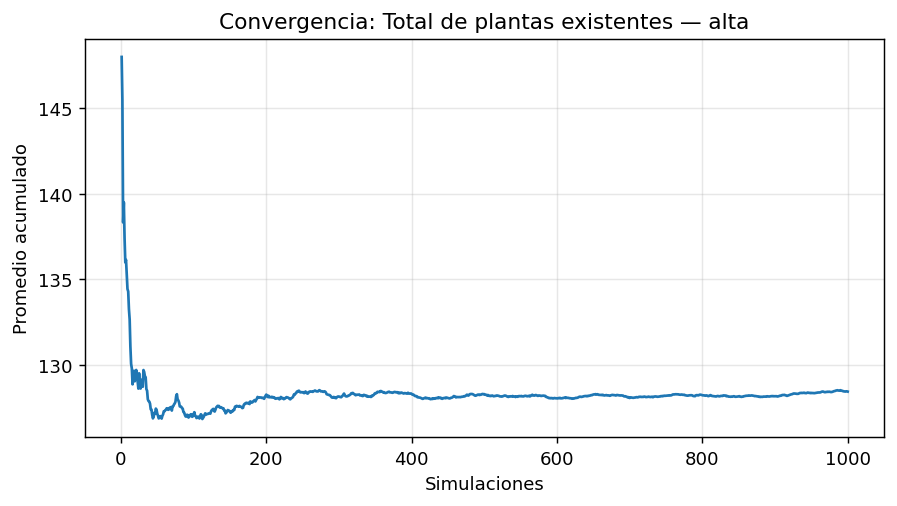

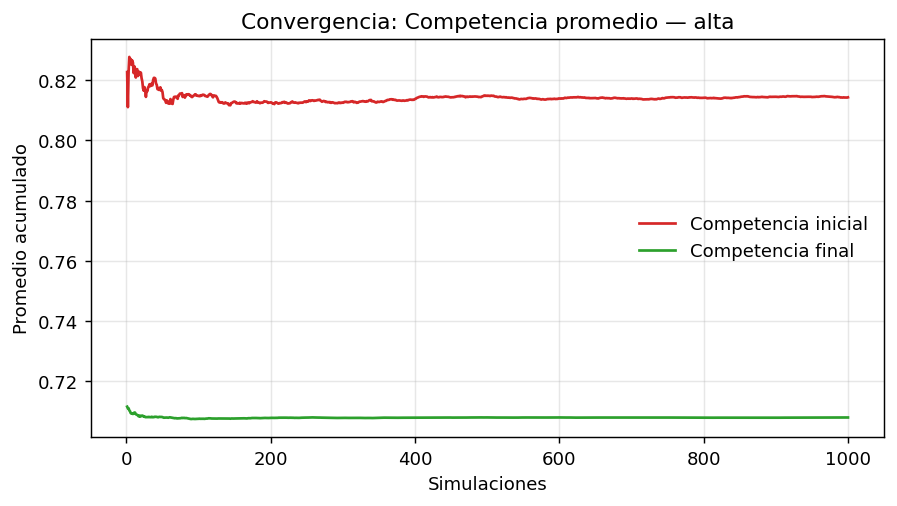

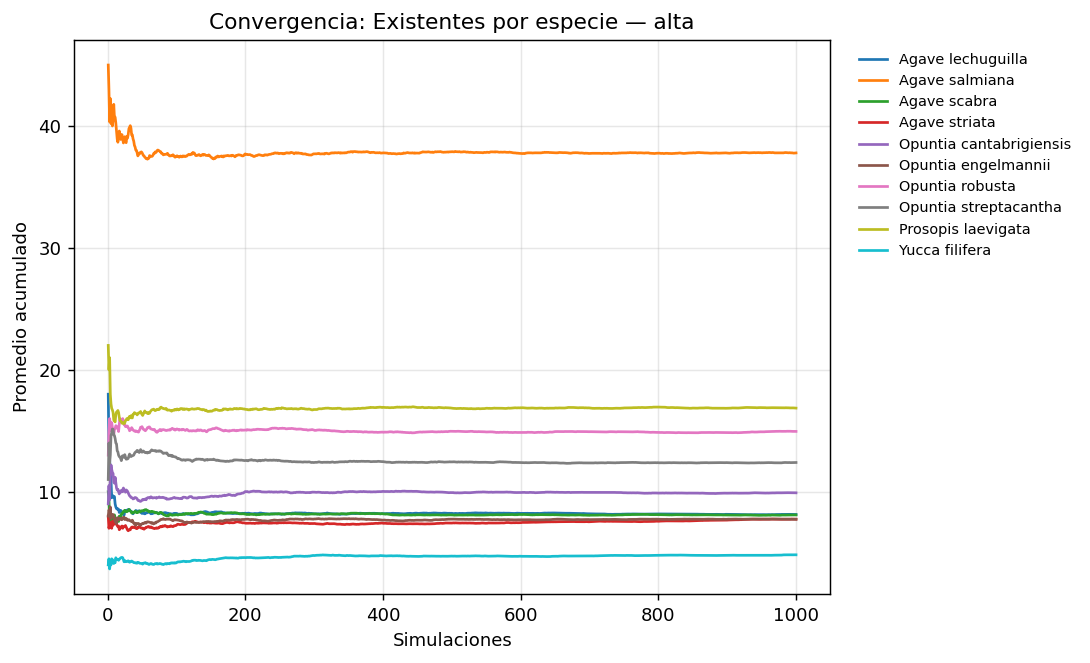

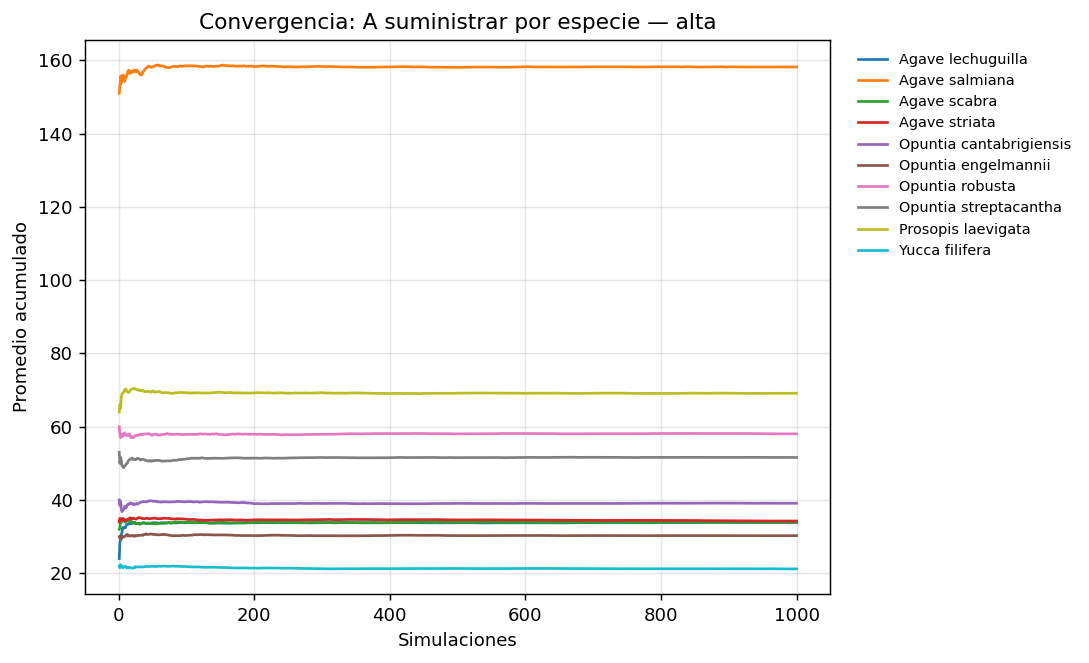

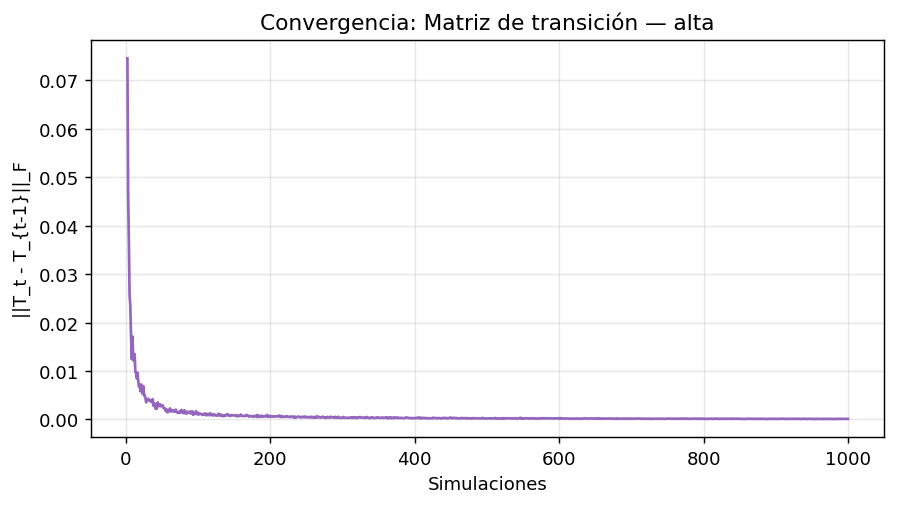

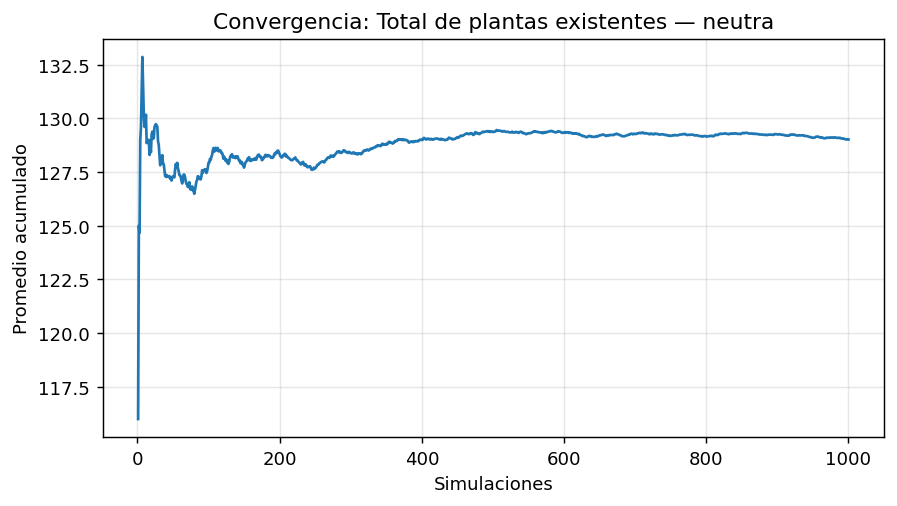

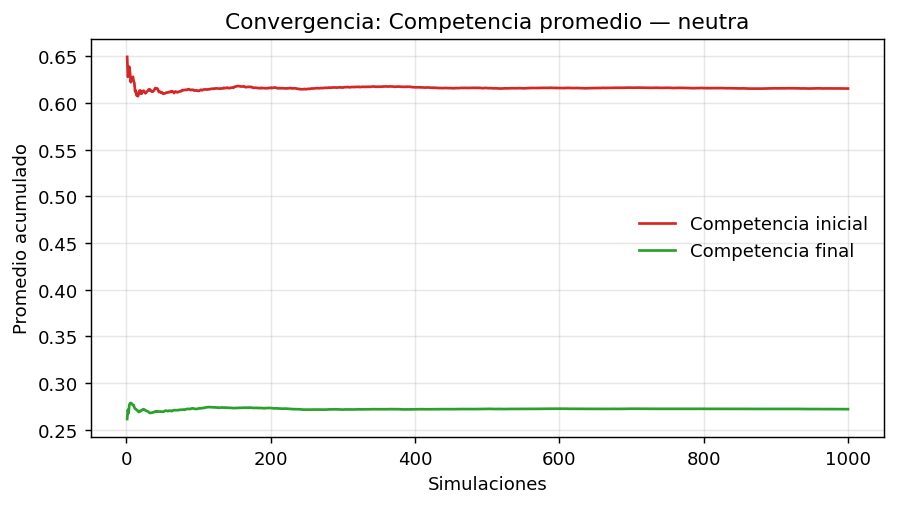

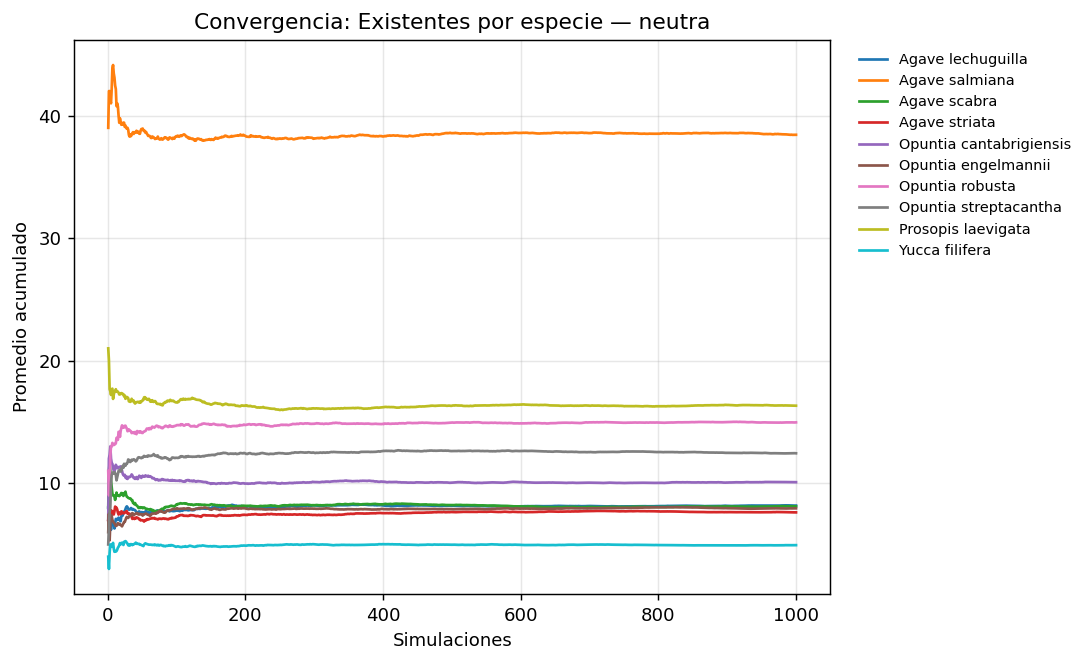

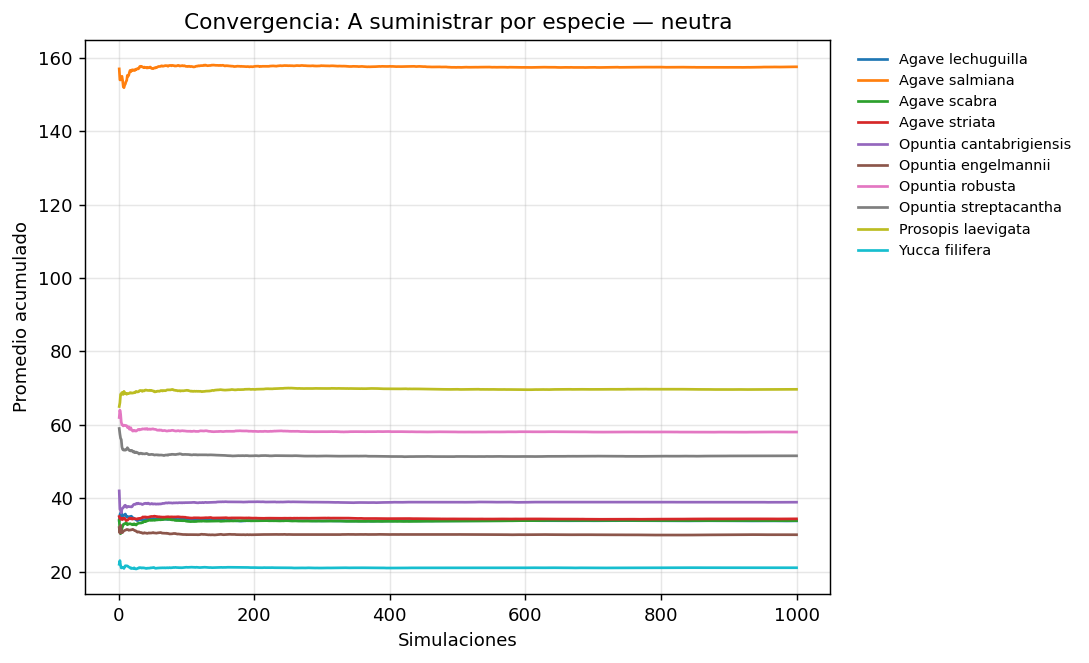

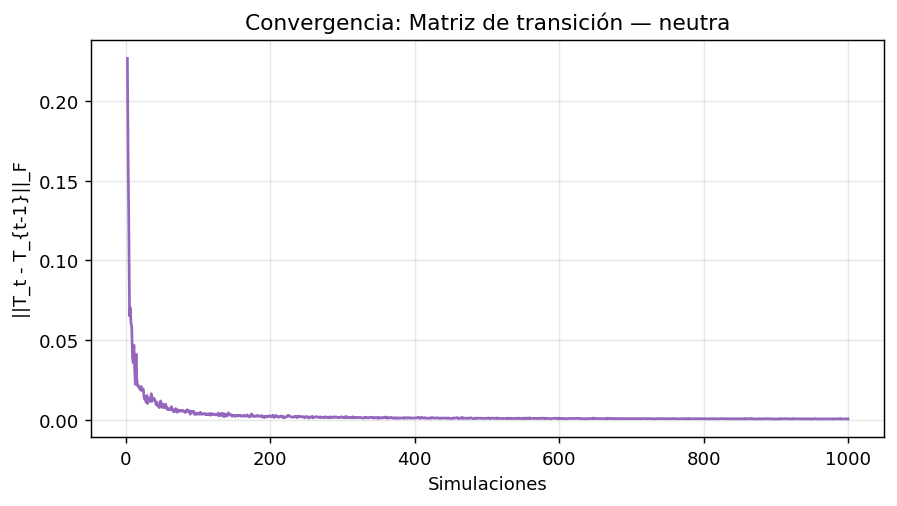

In [12]:
# === Convergencia de simulaciones (promedios acumulados) ===
# Grafica la convergencia por simulación de: total existentes, existentes por especie,
# a suministrar por especie, competencia (inicial/final) y una métrica para la matriz de transición.

def monte_carlo_convergencia(N_SIM, modos=("alta", "neutra"), seed_base: int | None = None, lambda_comp: float = 1.0):
    if 'probabilidades_especie' not in globals():
        raise NameError("No se encontró 'probabilidades_especie'. Ejecuta la celda de probabilidades antes de esta.")
    species_order = list(species_names)
    n_species = len(species_order)
    base_seed = int(SEED) if seed_base is None else int(seed_base)

    for modo in modos:
        # Series de promedios acumulados
        rm_exist_total_series = np.zeros(N_SIM, dtype=float)
        rm_comp_init_series = np.zeros(N_SIM, dtype=float)
        rm_comp_final_series = np.zeros(N_SIM, dtype=float)
        rm_exist_by_sp_series = np.zeros((N_SIM, n_species), dtype=float)
        rm_supply_by_sp_series = np.zeros((N_SIM, n_species), dtype=float)
        trans_frob_diff_series = np.zeros(N_SIM, dtype=float)

        # Acumuladores
        sum_exist_total = 0.0
        sum_exist_by_sp = np.zeros(n_species, dtype=float)
        sum_supply_by_sp = np.zeros(n_species, dtype=float)
        sum_comp_init = 0.0
        sum_comp_final = 0.0
        trans_counts_acc = np.zeros((n_species, n_species), dtype=np.int64)
        prev_trans_probs = None

        for s in range(N_SIM):
            t = s + 1
            rng_sim = np.random.default_rng(base_seed + s + (0 if modo == "alta" else 10_000_000))

            # Inicial: ocupación y especies preexistentes
            occupied = rng_sim.random(N_NODOS) < PRE_EXISTING_RATE
            n_planted = int(occupied.sum())
            if n_planted > 0:
                sp_idx = rng_sim.choice(n_species, size=n_planted, p=probs, replace=True)
                sp_assigned = [species_order[i] for i in sp_idx]
                planted_pts = coords[occupied]
                df_planted_local = pd.DataFrame({"x": planted_pts[:, 0], "y": planted_pts[:, 1], "species": sp_assigned})
            else:
                df_planted_local = pd.DataFrame(columns=["x", "y", "species"])

            # Metas y matriz de competencia
            target_counts, comp = cargar_metas_y_comp(species_order, modo=modo)

            # Asignación voraz (silenciosa)
            species_at, current_counts, final_counts, neighbors, species_at_init = _greedy_asignacion(
                target_counts, comp, species_order, coords, df_planted_local, lambda_comp=lambda_comp
            )

            # Actualiza acumuladores
            sum_exist_total += float(n_planted)
            sum_exist_by_sp += current_counts.astype(float)
            delta_supply = (final_counts - current_counts).astype(float)
            sum_supply_by_sp += delta_supply

            # Competencia
            comp_init = _competencia_promedio(species_at_init, comp, neighbors)
            comp_final = _competencia_promedio(species_at, comp, neighbors)
            sum_comp_init += comp_init
            sum_comp_final += comp_final

            # Matriz de transición acumulada y métrica de convergencia
            trans_counts_acc += _matriz_transicion(species_at, neighbors, n_species)
            # Estimador actual de transición (normalizado por filas)
            curr_trans_probs = np.zeros_like(trans_counts_acc, dtype=float)
            for i in range(n_species):
                row_sum = trans_counts_acc[i].sum()
                if row_sum > 0:
                    curr_trans_probs[i] = trans_counts_acc[i] / row_sum
            if prev_trans_probs is None:
                trans_frob_diff_series[s] = np.nan
            else:
                trans_frob_diff_series[s] = float(np.linalg.norm(curr_trans_probs - prev_trans_probs))
            prev_trans_probs = curr_trans_probs

            # Promedios acumulados (running mean)
            rm_exist_total_series[s] = sum_exist_total / t
            rm_comp_init_series[s] = sum_comp_init / t
            rm_comp_final_series[s] = sum_comp_final / t
            rm_exist_by_sp_series[s] = sum_exist_by_sp / t
            rm_supply_by_sp_series[s] = sum_supply_by_sp / t

        # Colores por especie
        tab10 = plt.get_cmap('tab10').colors
        color_map = {sp: tab10[i % len(tab10)] for i, sp in enumerate(species_order)}
        x = np.arange(1, N_SIM + 1)

        # 1) Total de existentes
        plt.figure(figsize=(7, 4), dpi=130)
        plt.plot(x, rm_exist_total_series, color="#1f77b4")
        plt.xlabel("Simulaciones")
        plt.ylabel("Promedio acumulado")
        plt.title(f"Convergencia: Total de plantas existentes — {modo}")
        plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

        # 2) Competencia inicial/final
        plt.figure(figsize=(7, 4), dpi=130)
        plt.plot(x, rm_comp_init_series, label="Competencia inicial", color="#d62728")
        plt.plot(x, rm_comp_final_series, label="Competencia final", color="#2ca02c")
        plt.xlabel("Simulaciones")
        plt.ylabel("Promedio acumulado")
        plt.title(f"Convergencia: Competencia promedio — {modo}")
        plt.legend(frameon=False)
        plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

        # 3) Existentes por especie
        plt.figure(figsize=(8.5, 5.2), dpi=130)
        for i, sp in enumerate(species_order):
            plt.plot(x, rm_exist_by_sp_series[:, i], label=sp, color=color_map[sp])
        plt.xlabel("Simulaciones")
        plt.ylabel("Promedio acumulado")
        plt.title(f"Convergencia: Existentes por especie — {modo}")
        plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, fontsize=8)
        plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

        # 4) A suministrar por especie
        plt.figure(figsize=(8.5, 5.2), dpi=130)
        for i, sp in enumerate(species_order):
            plt.plot(x, rm_supply_by_sp_series[:, i], label=sp, color=color_map[sp])
        plt.xlabel("Simulaciones")
        plt.ylabel("Promedio acumulado")
        plt.title(f"Convergencia: A suministrar por especie — {modo}")
        plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, fontsize=8)
        plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

        # 5) Convergencia de la matriz de transición (norma de Frobenius entre estimaciones sucesivas)
        plt.figure(figsize=(7, 4), dpi=130)
        # Oculta el primer NaN
        y = trans_frob_diff_series.copy()
        if np.isnan(y[0]):
            y[0] = np.nan
        plt.plot(x, y, color="#9467bd")
        plt.xlabel("Simulaciones")
        plt.ylabel("||T_t - T_{t-1}||_F")
        plt.title(f"Convergencia: Matriz de transición — {modo}")
        plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

# Ejecuta los gráficos de convergencia (ajusta N_SIM si deseas)
monte_carlo_convergencia(N_SIM=1000, modos=("alta", "neutra"), lambda_comp=LAMBDA_COMP)

